<div align='center'><img src='model_income.jpeg' width=480/></div>

# Прогноз дохода клиентов

 - Задача прогнозирования дохода имеет особенное значение в Банке. 
Эта информация помогает точнее и более релевантно подбирать продукты и условия их приобретения, что в свою очередь вносит существенный вклад в прибыль Банка. 
 - Помимо ценности для Банка, оценка дохода является регуляторным требованием ЦБ в части расчета предельно допустимой кредитной нагрузки для клиента (далее ПДН)
 
# Данные
- train.csv обучающая выборка
- test.csv выборка для скоринга
- description.xlsx - описание признаков

# Метрика качества
<a href='https://kaggle-metrics.readthedocs.io/en/latest/_modules/kaggle_metrics/regression.html'>WMAE</a> - Взвешенная средняя абсолютная ошибка

# Импорт библиотек

In [35]:
import shap

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from deepchecks.tabular import Dataset
from deepchecks.tabular.checks import FeatureDrift
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from catboost import CatBoostRegressor, Pool, cv, EShapCalcType, EFeaturesSelectionAlgorithm


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 200)

# Функции

### Функция для расчета метрики

In [2]:
def weighted_mean_absolute_error(y_true, y_pred, weights):

    '''

    Weighted mean absolute error.

    Parameters
    ----------
    y_true: ndarray
        Ground truth
    y_pred: ndarray
        Array of predictions

    Returns
    -------
    rmsle: float
        Weighted mean absolute error

    References
    ----------
    .. [1] https://kaggle-metrics.readthedocs.io/en/latest/_modules/kaggle_metrics/regression.html

    '''
    
    return (weights * np.abs(y_true - y_pred)).mean()

### Функция для обучения базовой модели

In [3]:
def fit_catboost(features_train, 
                 features_val, 
                 target_train, 
                 target_val, 
                 cat_features, 
                 n_iter=500,
                 train_weight=None,
                 val_weight=None,
                 plot=True):
    
    pool_train = Pool(
        features_train,
        target_train,
        weight = train_weight,
        cat_features = cat_features
    )

    pool_val = Pool(
        features_val,
        target_val,
        weight = val_weight,
        cat_features = cat_features
    )

    model = CatBoostRegressor(
        iterations= n_iter,
        learning_rate=0.05,
        loss_function='RMSE',
        early_stopping_rounds = 15,
        random_seed = 42
    )

    model.fit(
        pool_train,
        eval_set=pool_val,
        verbose=100,
        plot=plot
    )

    return model

# Чтение данных

In [4]:
train_df = pd.read_csv('data/train.csv', sep=";", decimal=",", encoding="windows-1251")
test_df = pd.read_csv('data/test.csv', sep=";", decimal=",", encoding="windows-1251")

features_description = (
    pd.read_excel('data/description.xlsx', index_col='field')
    .to_dict()['description']
)

train_df.shape, test_df.shape

((205962, 235), (37183, 233))

# Предварительный анализ EDA

In [5]:
display(train_df.info())
display(train_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205962 entries, 0 to 205961
Columns: 235 entries, client_id to productionyear
dtypes: float64(212), int64(1), object(22)
memory usage: 369.3+ MB


None

,client_id,feature_date,target,w,accum_rur_amt_cm_avg_div_v2,addrref,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__bilety_na_kontserty_i_v_teatry,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__brokerskie_uslugi,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__hosting,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__spa_sauny_bani,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__tovary_dlja_detej,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__turisticheskie_agenstva,amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__marketplejsy,amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__nalogi,amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__ohota_i_rybalka,amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__prochie_bilety,atravel,avg_3m_hotels,avg_6m_building_services,avg_6m_money_transactions,avg_6m_personal_services,avg_6m_transportation,avg_by_category__amount__sum__cashflowcategory_name__detskie_igrushki,avg_by_category__amount__sum__cashflowcategory_name__investitsii,avg_by_category__amount__sum__cashflowcategory_name__odezhda_dlja_beremennyh,avg_by_category__amount__sum__cashflowcategory_name__vydacha_nalichnyh_v_bankomate,avg_by_category__amount__sum__cashflowcategory_name__zdorove,avg_by_category__amount__sum__cashflowcategory_name__zooparki,avg_cnt_daily_transactions_90d,avg_debet_turn_rur,avg_percents_inc,bki_total_ip_max_limit,by_category__amount__sum__eoperation_type_name__perevod_mezhdu_svoimi_schetami,by_category__amount__sum__eoperation_type_name__platezh_cherez_vidzhet_moj_mobilnyj,by_category__amount__sum__eoperation_type_name__pokupka_paja,by_category__amount__sum__eoperation_type_name__vneshnij_perevod_rur,calls_weight_v2,card_dda_rur_amt_cm_avg_div_v2,cc_other_rate_max_2avg_prop,channel_agentskij_kanal_voc_features_12m_avg_mark,channel_agentskij_kanal_voc_features_12m_cnt_mark,channel_bankomaty_voc_features_36m_avg_mark,channel_bankomaty_voc_features_36m_voc_without_marks_portion,channel_bankomaty_voc_features_3m_mark_eq_5_flag,channel_bankomaty_voc_features_full_mark_eq_5_flag,channel_bankomaty_voc_features_full_voc_not_null_flag,channel_chat_s_operatorom_alfainvestitsii_voc_features_12m_avg_mark,channel_chat_s_operatorom_alfainvestitsii_voc_features_36m_mark_not_null_flag,channel_chat_s_operatorom_voc_features_12m_cnt_mark,channel_chat_s_operatorom_voc_features_12m_mark_eq_3_flag,channel_chat_s_operatorom_voc_features_12m_voc_with_expert_cnt,channel_chat_s_operatorom_voc_features_3m_mark_eq_4_flag,channel_chat_s_operatorom_voc_features_full_voc_without_marks_portion,channel_chatbot_alfainvestitsii_voc_features_12m_mark_in_4_5_flag,channel_chatbot_alfainvestitsii_voc_features_12m_voc_with_expert_portion,channel_chatbot_alfainvestitsii_voc_features_36m_mark_eq_3_flag,channel_chatbot_alfainvestitsii_voc_features_36m_min_mark,channel_chatbot_alfainvestitsii_voc_features_3m_mark_eq_5_flag,channel_chatbot_alfainvestitsii_voc_features_3m_mark_in_4_5_flag,channel_chatbot_alfainvestitsii_voc_features_full_avg_mark,channel_chatbot_voc_features_12m_mark_in_1_3_flag,channel_chatbot_voc_features_12m_voc_with_expert_portion,channel_chatbot_voc_features_full_voc_without_marks_portion,channel_collection_voc_features_36m_cnt_mark,channel_collection_voc_features_36m_mark_eq_2_flag,channel_collection_voc_features_36m_voc_not_null_flag,channel_collection_voc_features_3m_voc_with_expert_portion,channel_collection_voc_features_full_voc_without_marks_portion,channel_finansovyj_sovetnik_voc_features_36m_avg_mark,channel_finansovyj_sovetnik_voc_features_3m_voc_with_expert_portion,channel_finansovyj_sovetnik_voc_features_full_avg_mark,channel_finansovyj_sovetnik_voc_features_full_voc_with_expert_cnt,channel_frodmonitoring_voc_features_12m_mark_eq_2_flag,channel_frodmonitoring_voc_features_12m_max_mark,channel_frodmonitoring_voc_features_3m_mark_in_4_5_flag,channel_frodmon

In [6]:
features = list(train_df.drop(['client_id', 'feature_date', 'target', 'w'], axis=1).columns)
train_df[features].select_dtypes('object').head()

,addrref,bki_total_ip_max_limit,hdb_bki_active_cc_cnt,hdb_bki_active_ip_max_outstand,hdb_bki_active_micro_max_outstand,hdb_bki_active_pil_max_overdue,hdb_bki_other_active_auto_month_payments_sum,hdb_bki_total_cc_max_limit,hdb_bki_total_ip_cnt,hdb_bki_total_max_limit,hdb_bki_total_max_overdue_sum,hdb_bki_total_pil_max_limit,main_last_position_ccode,main_pre_last_position_ccode,oldest_campaignsegment_ccode_for_nss,oldest_campaignsegment_ccode_for_pil,part_last_position_ccode,part_pre_last_position_ccode,segment,brand,model
0,Свердловская область,NaN,2.0,1006774.6,NaN,0.0,NaN,170000.0,1.0,4250000.0,235937.0,220000.0,NaN,NaN,NaN,PIL2CC,NaN,NaN,Mass Affluent,NaN,NaN
1,Новосибирская область,NaN,6.0,NaN,NaN,0.0,NaN,110000.0,0.0,183500.0,2527.0,183500.0,NaN,NaN,ACFYN_NZP,PIL2PIL,NaN,NaN,Mass Affluent,NaN,NaN
2,Новосибирская область,NaN,4.0,NaN,NaN,0.0,NaN,65000.0,0.0,558500.0,7678.0,558500.0,NaN,NaN,ACFYN_NZP,PIL2PIL,NaN,NaN,Mass Affluent,NaN,NaN
3,Московская область,NaN,0.0,646694.0,NaN,NaN,NaN,0.0,3.0,1780000.0,0.0,427000.0,NaN,NaN,ACFYN_NZP,PIL2PAY,NaN,NaN,Mass Affluent,NaN,NaN
4,Краснодарский край,NaN,3.0,NaN,NaN,14264.13,NaN,62500.0,0.0,1120000.0,14264.13,1120000.0,NaN,NaN,ACFYN_NZP,PIL2PAY,NaN,NaN,Mass,NaN,NaN


### Поправляем типы данных для фичей

In [7]:
print('Количество униклаьных значений по фиче:')
for f in train_df[features].select_dtypes('object').columns:
    print(f"{f}: {train_df[f].value_counts().count()}")

Количество униклаьных значений по фиче:
addrref: 59
bki_total_ip_max_limit: 2763
hdb_bki_active_cc_cnt: 60
hdb_bki_active_ip_max_outstand: 43267
hdb_bki_active_micro_max_outstand: 5458
hdb_bki_active_pil_max_overdue: 24365
hdb_bki_other_active_auto_month_payments_sum: 3533
hdb_bki_total_cc_max_limit: 9991
hdb_bki_total_ip_cnt: 15
hdb_bki_total_max_limit: 52263
hdb_bki_total_max_overdue_sum: 56162
hdb_bki_total_pil_max_limit: 54202
main_last_position_ccode: 9207
main_pre_last_position_ccode: 5192
oldest_campaignsegment_ccode_for_nss: 56
oldest_campaignsegment_ccode_for_pil: 13
part_last_position_ccode: 1236
part_pre_last_position_ccode: 1325
segment: 3
brand: 422
model: 2397


В соответствии с описанием фичей было выяснено, что для всех фичей, которые начинаются с 'hdb_bki' требуется выставить тип данных float

In [8]:
newtype_feats = [
    'bki_total_ip_max_limit',
    'hdb_bki_active_cc_cnt',
    'hdb_bki_active_ip_max_outstand',
    'hdb_bki_active_micro_max_outstand',
    'hdb_bki_active_pil_max_overdue',
    'hdb_bki_other_active_auto_month_payments_sum',
    'hdb_bki_total_cc_max_limit',
    'hdb_bki_total_ip_cnt',
    'hdb_bki_total_max_limit',
    'hdb_bki_total_max_overdue_sum',
    'hdb_bki_total_pil_max_limit'
]

test_df[newtype_feats] = test_df[newtype_feats].astype('float64')
test_df['feature_date'] = test_df['feature_date'].astype('datetime64[ns]')

train_df[newtype_feats] = train_df[newtype_feats].astype('float64')
train_df['feature_date'] = train_df['feature_date'].astype('datetime64[ns]')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205962 entries, 0 to 205961
Columns: 235 entries, client_id to productionyear
dtypes: datetime64[ns](1), float64(223), int64(1), object(10)
memory usage: 369.3+ MB


In [9]:
cat_features = list(train_df[features].select_dtypes('object').columns)
num_features = list(set(features) - set(cat_features))

len(features), len(cat_features), len(num_features)

(231, 10, 221)

In [10]:
train_df[cat_features].describe()

,addrref,main_last_position_ccode,main_pre_last_position_ccode,oldest_campaignsegment_ccode_for_nss,oldest_campaignsegment_ccode_for_pil,part_last_position_ccode,part_pre_last_position_ccode,segment,brand,model
count,179914,30398,23648,123425,142384,5535,3694,169609,8623,8658
unique,59,9207,5192,56,13,1236,1325,3,422,2397
top,г. Москва,БЕЗРАБОТНЫЙ,БЕЗРАБОТНЫЙ,ACFYN_NZP,PIL2PIL,БЕЗРАБОТНЫЙ,БЕЗРАБОТНЫЙ,Mass Affluent,ВАЗ,БЕЗ МОДЕЛИ
freq,63973,2872,10525,77486,45195,2718,686,76394,531,141


<Axes: ylabel='Density'>

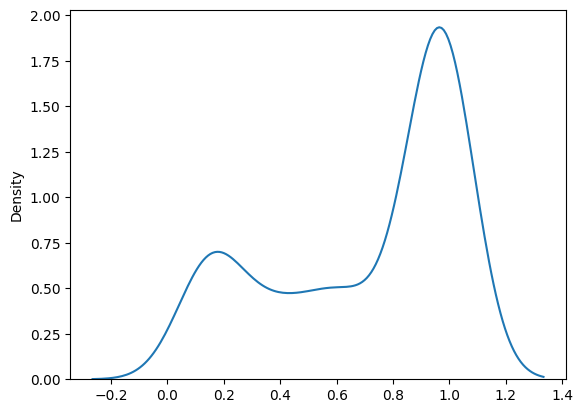

In [11]:
sns.kdeplot((train_df[features].isna().sum() / train_df.shape[0]))

### Анализ категорильных фичей

In [12]:
# сколько всего записей, где известна должность, но не известна зп?
train_df.loc[
    (train_df['worksalary_rur_amt'].isna())
    & (~train_df['part_last_position_ccode'].isna())
].shape

(4184, 235)

In [13]:
# df, содержащий медианные зарплаты для должностей по всем данным
median_worksalary = (
    pd.concat([train_df[features], test_df[features]], axis=0)
    .dropna(subset = 'worksalary_rur_amt')
    .groupby('part_last_position_ccode', as_index=False)
    ['worksalary_rur_amt'].median()
    .rename(columns={'worksalary_rur_amt': 'median_worksalary_rur_amt'})
)
median_worksalary.head()

,part_last_position_ccode,median_worksalary_rur_amt
0,АВТОМЕХАНИК,158892.5
1,АДМИНИСТРАТОР,180000.0
2,АНАЛИТИК,100000.0
3,Администратор,60000.0
4,Администратор магазина,70000.0


In [14]:
test_df = test_df.merge(median_worksalary, on='part_last_position_ccode', how='left')
test_df['worksalary_rur_amt'] = test_df['worksalary_rur_amt'].fillna(test_df['median_worksalary_rur_amt'])
test_df.drop('median_worksalary_rur_amt', axis=1, inplace=True)

train_df = train_df.merge(median_worksalary, on='part_last_position_ccode', how='left')
train_df['worksalary_rur_amt'] = train_df['worksalary_rur_amt'].fillna(train_df['median_worksalary_rur_amt'])
train_df.drop('median_worksalary_rur_amt', axis=1, inplace=True)

train_df.loc[
    (train_df['worksalary_rur_amt'].isna())
    & (~train_df['part_last_position_ccode'].isna())
].shape

(1029, 235)

In [15]:
# заполняем пропуски в категориальных
train_df[cat_features] = train_df[cat_features].fillna('miss_value')
test_df[cat_features] = test_df[cat_features].fillna('miss_value')

In [17]:
profile = ProfileReport(train_df[cat_features], title="Profiling cat_features Report")
profile

### Как вес для метрики WMAE зависит от таргета?

In [18]:
train_df['w'].describe()

count    2.059620e+05
mean     5.336670e-01
std      5.158126e-01
min      5.017421e-07
25%      2.219606e-01
50%      4.098650e-01
75%      6.254455e-01
max      2.362991e+00
Name: w, dtype: float64

d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='w', ylabel='target'>

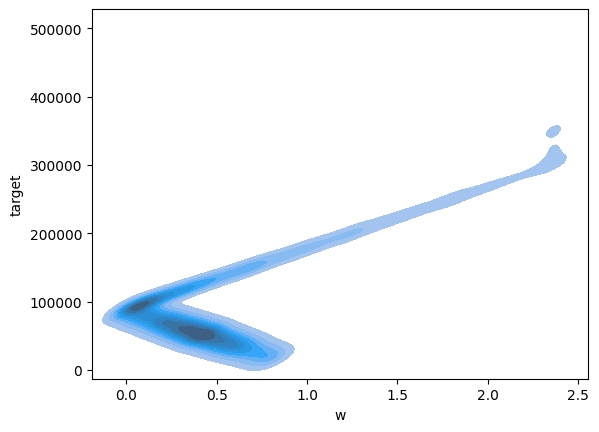

In [17]:
feat_array_ind = (
    train_df
        [
            train_df['target']
            .between(
                np.percentile(train_df['target'].dropna(), 1),
                np.percentile(train_df['target'].dropna(), 99)
        )
    ].index
)
tmp = train_df.loc[feat_array_ind]

sns.kdeplot(
    x=tmp['w'],
    y=tmp['target'],
    fill=True,
)

### Как таргет зависит от сегмента

In [18]:
train_df['segment'].value_counts()

segment
Mass Affluent    76394
Mass             72246
miss_value       36353
Affluent         20969
Name: count, dtype: int64

d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='encoded_segment', ylabel='target'>

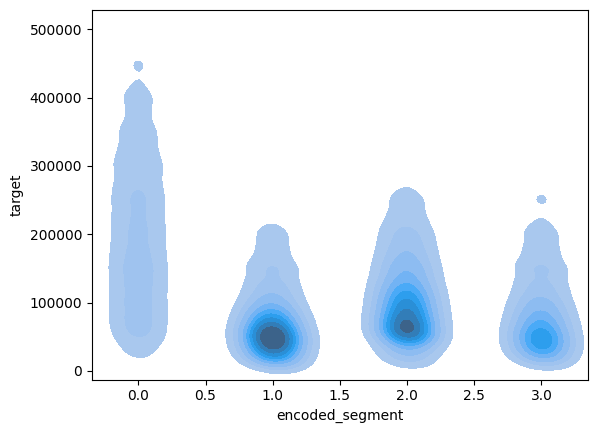

In [164]:
segment_le = LabelEncoder()
tmp['encoded_segment'] = segment_le.fit_transform(tmp['segment'])

sns.kdeplot(
    x=tmp['encoded_segment'],
    y=tmp['target'],
    fill=True,
)

### Из каких значений состоит таргет?

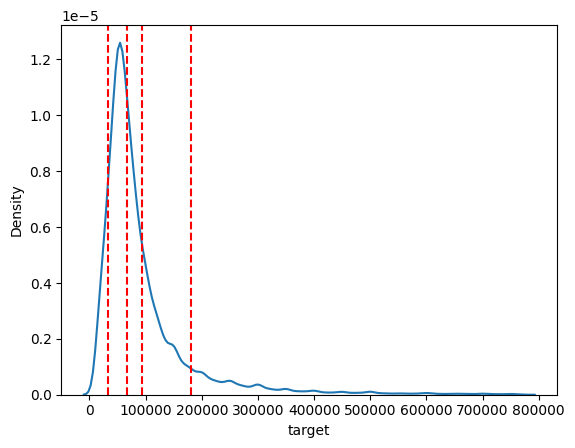

In [16]:
sns.kdeplot(train_df['target'])
plt.axvline(x=train_df['target'].median(), color='r', linestyle='--')
plt.axvline(x=train_df['target'].quantile(0.9), color='r', linestyle='--')
plt.axvline(x=train_df['target'].quantile(0.7), color='r', linestyle='--')
plt.axvline(x=train_df['target'].quantile(0.1), color='r', linestyle='--')

In [20]:
(train_df['target'].astype('int') == train_df['target']).value_counts()/train_df.shape[0]

target
False    0.685185
True     0.314815
Name: count, dtype: float64

### Выводы
1. Много фичей с большой долей пропущенных значений
2. Клиентам с большим доходом присвоены высокие веса для метрики WMAE
3. По колонке segment клиенты с высокой зп имеют значение Affluent 
4. На 31% таргет состоит из значений без дрообной части. Возможно округление предсказания модели даст эффект
5. Есть потенциально хорошие категориальные фичи (связанные с должностью и автомобилем), но они слабо заполнены

# Инженерия фич

In [17]:
train_df['feature_date_year'] = train_df['feature_date'].dt.year
train_df['feature_date_month'] = train_df['feature_date'].dt.month
train_df['feature_date_day'] = train_df['feature_date'].dt.day

test_df['feature_date_year'] = test_df['feature_date'].dt.year
test_df['feature_date_month'] = test_df['feature_date'].dt.month
test_df['feature_date_day'] = test_df['feature_date'].dt.day

In [18]:
features = list(train_df.drop(['client_id', 'feature_date', 'target', 'w'], axis=1).columns)

cat_features = list(train_df[features].select_dtypes('object').columns)
num_features = list(set(features) - set(cat_features))

len(features), len(cat_features), len(num_features)

(234, 10, 224)

# Обучение модели

In [19]:
features_train, features_val, target_train, target_val, w_train, w_val = train_test_split(
    train_df[features],
    train_df['target'],
    train_df['w'],
    test_size=0.3,
    random_state=42
)

## Обучение модели на всех фичах

In [20]:
model = fit_catboost(features_train, features_val, target_train, target_val, cat_features, 500)


WMAE = weighted_mean_absolute_error(target_val, model.predict(features_val), w_val)
print(f"WMAE = {WMAE:.2f}")
print(f"Overfit: {model.evals_result_['validation']['RMSE'][-1] - model.evals_result_['learn']['RMSE'][-1]}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 86722.6308951	test: 86912.3300717	best: 86912.3300717 (0)	total: 306ms	remaining: 2m 32s
100:	learn: 61242.8780421	test: 61709.5908836	best: 61709.5908836 (100)	total: 15.4s	remaining: 1m
200:	learn: 59115.7138071	test: 60096.3026703	best: 60096.3026703 (200)	total: 29.7s	remaining: 44.1s
300:	learn: 57726.3478420	test: 59275.5505979	best: 59275.5505979 (300)	total: 44.2s	remaining: 29.2s
400:	learn: 56666.7545007	test: 58823.9338964	best: 58823.9338964 (400)	total: 58.3s	remaining: 14.4s
499:	learn: 55788.3122092	test: 58541.6216097	best: 58541.6216097 (499)	total: 1m 11s	remaining: 0us

bestTest = 58541.62161
bestIteration = 499

WMAE = 31676.37
Overfit: 2753.309400453094


### Улучшится ли метрика при округлении таргета?

In [74]:
# до целых
WMAE = weighted_mean_absolute_error(target_val, np.round(model.predict(features_val)), w_val)
print(WMAE)
# до тысяч
WMAE = weighted_mean_absolute_error(target_val, np.round(model.predict(features_val), decimals=-3), w_val)
print(WMAE)

31676.36766167503
31674.777249726183


Вывод:  
Округление очень слабо влияет на метрику

Text(0.5, 1.0, 'Residual Plot')

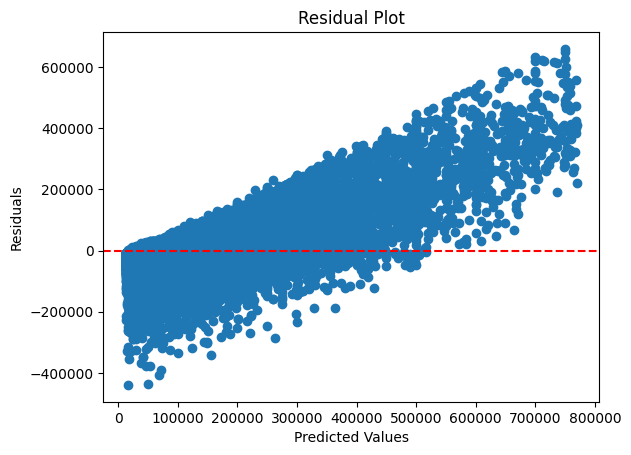

In [21]:
# Plot Residuals
residuals = target_val - model.predict(features_val)
plt.scatter(target_val, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

Вывод:  
Модель завышает предсказания для клиентов с низкой зарплатой и занижает для клиентов с высокой зарплатой.

In [38]:
pred_val = model.predict(features_val)

prediction_df = pd.DataFrame()
prediction_df['target_val'] = target_val
prediction_df['w'] = w_val
prediction_df['pred'] = pred_val
prediction_df['mae'] = np.abs(np.subtract(target_val, pred_val))
prediction_df['wmae'] = np.abs(np.subtract(target_val, pred_val)) * w_val.values
prediction_df['mse'] = np.square(np.subtract(target_val, pred_val))

### Зависит ли степень ошибки от величины таргета или веса?

d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\seaborn\_oldcore

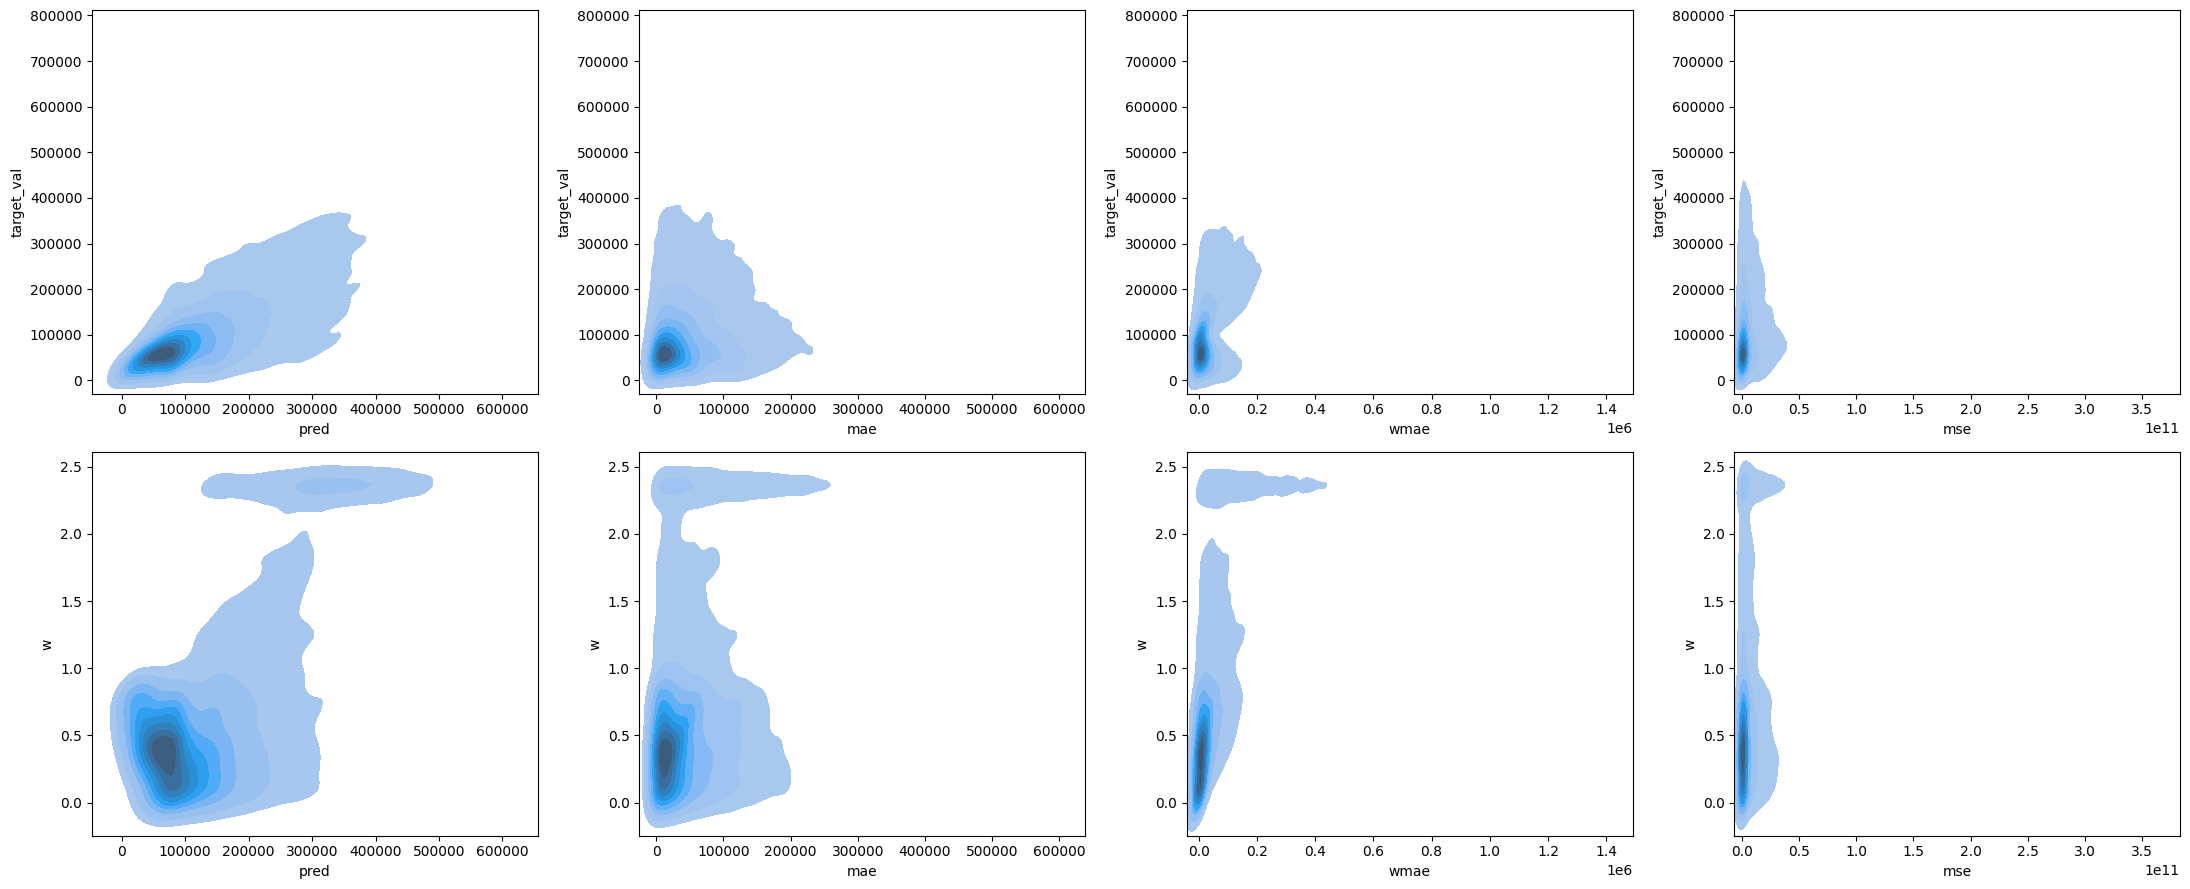

In [239]:
fig, axes = plt.subplots(2, 4, figsize=(22, 9))
i = 0

for col in ['target_val', 'w']:
    for feature in ['pred', 'mae', 'wmae', 'mse']:
        ax = axes[i // 4, i % 4]
        sns.kdeplot(
            x=prediction_df[feature],
            y=prediction_df[col],
            fill=True,
            ax=ax
        )
        i += 1
fig.tight_layout()

### Важность признаков

d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\shap\plots\_beeswarm.py:960: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



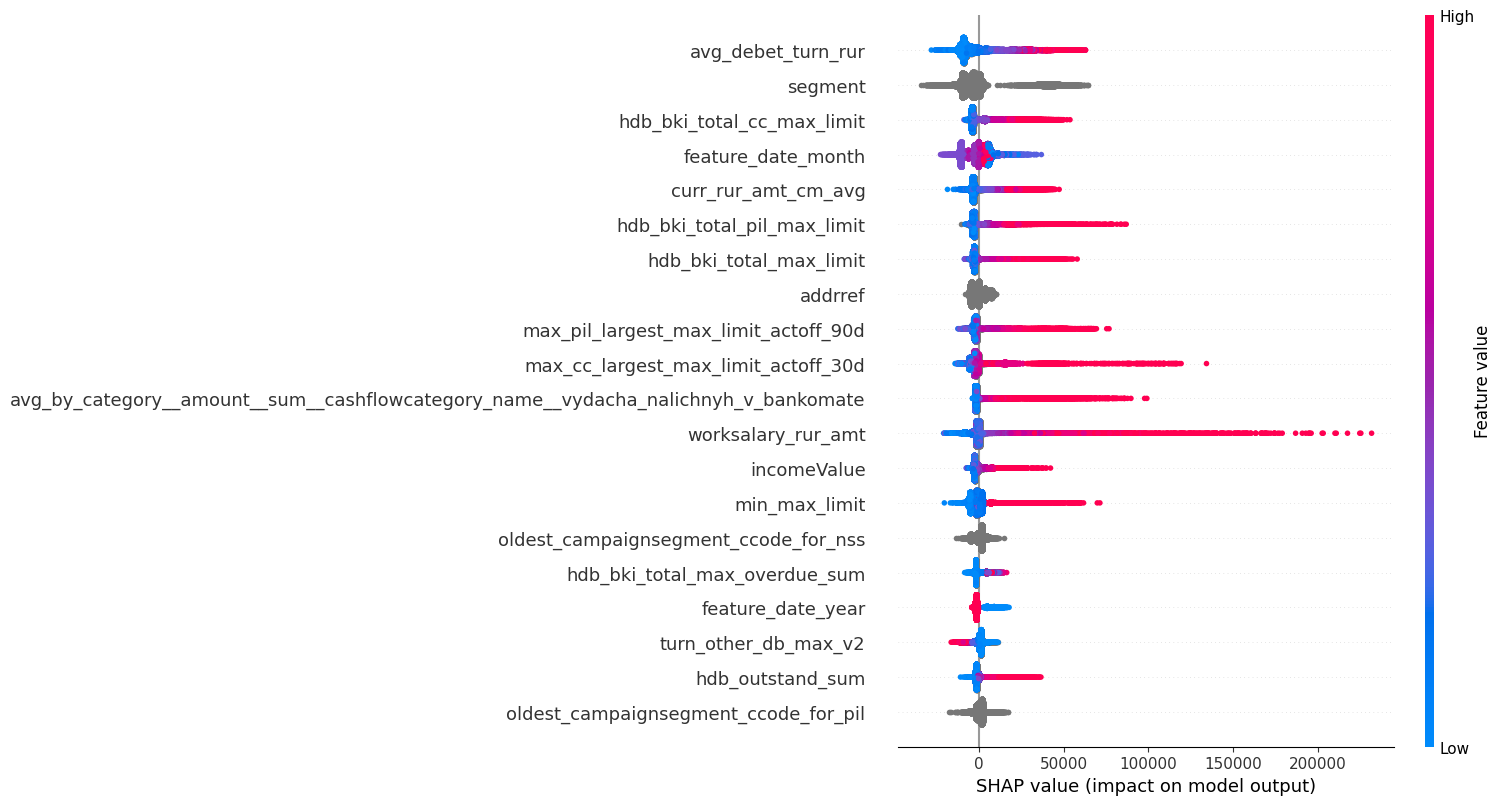

In [22]:
shap_values = (
    shap
    .TreeExplainer(model)
    .shap_values(features_val)
)
shap.summary_plot(shap_values, features_val)

In [23]:
shap_importance = (
    pd.DataFrame(
        {"feature":  features_train.columns, "importance": np.mean(np.abs(shap_values), axis=0)}
    ).sort_values("importance", ascending=False, ignore_index=True)
)
shap_importance.head()

,feature,importance
0,avg_debet_turn_rur,10299.575973
1,segment,8917.864137
2,hdb_bki_total_cc_max_limit,5507.870464
3,feature_date_month,5348.677286
4,curr_rur_amt_cm_avg,5136.231487


## Обучение модели на всех фичах с весом

In [402]:
model = fit_catboost(features_train, features_val, target_train, target_val, cat_features, 500, w_train, w_val)

WMAE = weighted_mean_absolute_error(target_val, model.predict(features_val), w_val)
print(f"WMAE = {WMAE:.2f}")
print(f"Overfit: {model.evals_result_['validation']['RMSE'][-1] - model.evals_result_['learn']['RMSE'][-1]}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 150027.6909213	test: 150324.2707219	best: 150324.2707219 (0)	total: 147ms	remaining: 1m 13s
100:	learn: 95991.8390262	test: 97338.1509442	best: 97338.1509442 (100)	total: 15.6s	remaining: 1m 1s
200:	learn: 92338.7683729	test: 94922.6179341	best: 94922.6179341 (200)	total: 31.5s	remaining: 46.9s
300:	learn: 89810.2113494	test: 93829.2886390	best: 93829.2886390 (300)	total: 48.2s	remaining: 31.8s
400:	learn: 87757.4519663	test: 93171.2169667	best: 93171.2169667 (400)	total: 1m 3s	remaining: 15.8s
499:	learn: 86042.9455117	test: 92707.0016433	best: 92707.0016433 (499)	total: 1m 19s	remaining: 0us

bestTest = 92707.00164
bestIteration = 499

WMAE = 31488.38
Overfit: 6664.056131617748


Text(0.5, 1.0, 'Residual Plot')

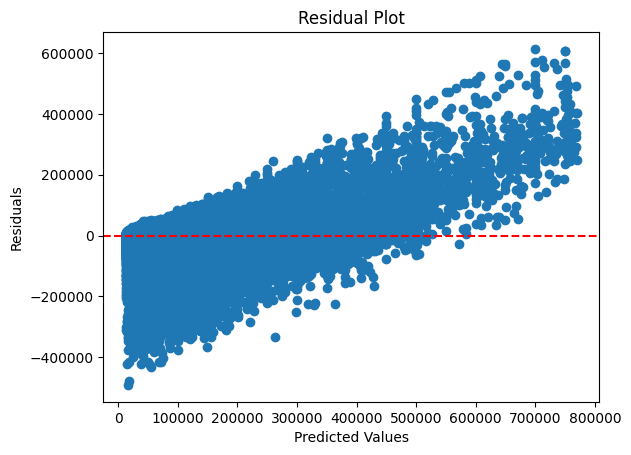

In [405]:
residuals = target_val - model.predict(features_val)
plt.scatter(target_val, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\shap\plots\_beeswarm.py:960: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



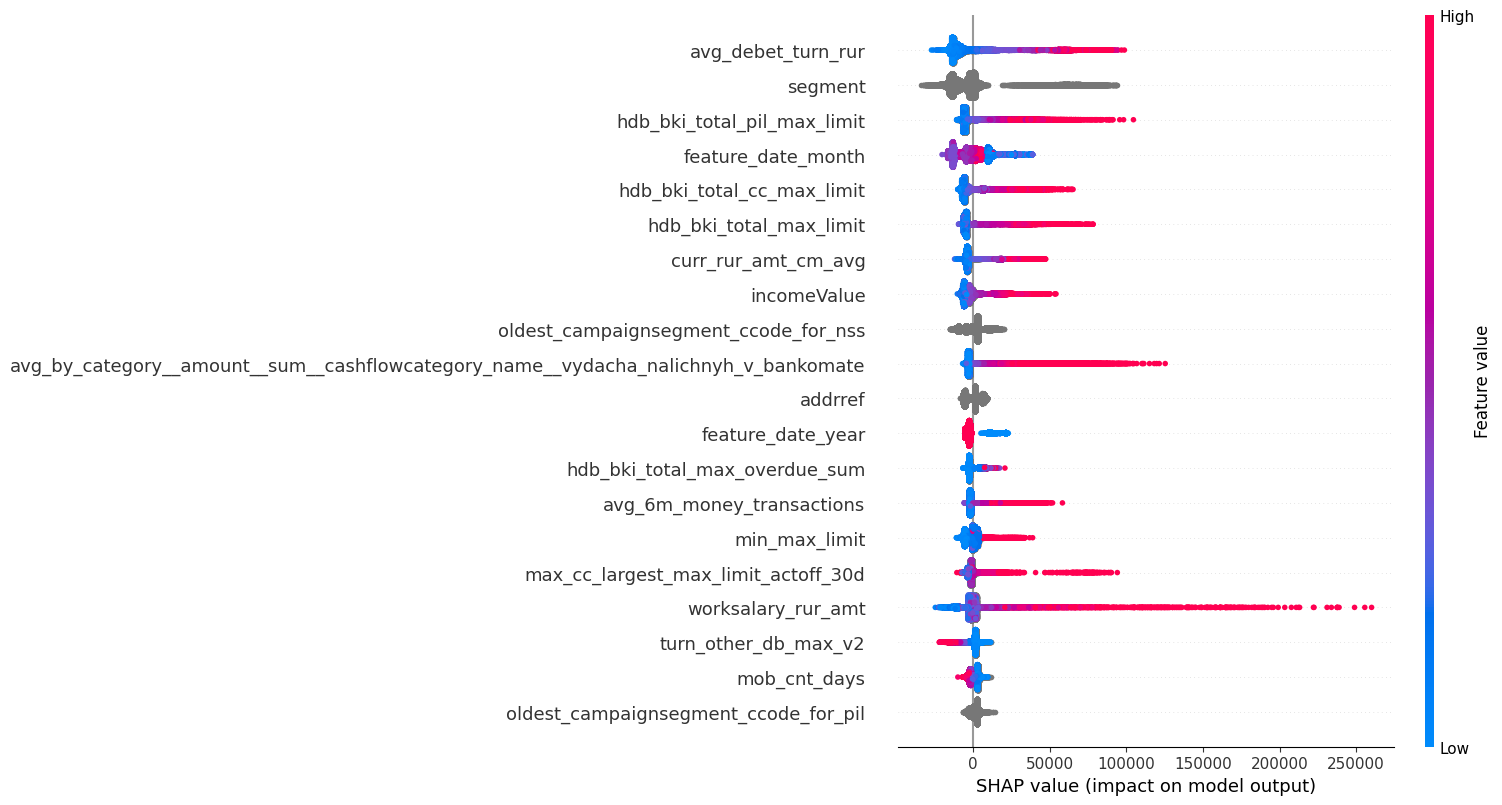

In [406]:
shap_values = (
    shap
    .TreeExplainer(model)
    .shap_values(features_val)
)
shap.summary_plot(shap_values, features_val)

Вывод:  
Добавление параметра weight в модель немного улучшает качество, но сильно увеличивает вероятность переобучения

## Обучение модели на всех фичах с весом в качестве фичи

In [407]:
model = fit_catboost(
    pd.concat([features_train, w_train], axis=1), 
    pd.concat([features_val, w_val], axis=1), 
    target_train, 
    target_val, 
    cat_features, 
    500
)

WMAE = weighted_mean_absolute_error(target_val, model.predict(pd.concat([features_val, w_val], axis=1)), w_val)
print(f"WMAE = {WMAE:.2f}")
print(f"Overfit: {model.evals_result_['validation']['RMSE'][-1] - model.evals_result_['learn']['RMSE'][-1]}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 84761.8845961	test: 84947.0437419	best: 84947.0437419 (0)	total: 160ms	remaining: 1m 20s
100:	learn: 30149.3999964	test: 30281.3308974	best: 30281.3308974 (100)	total: 15.8s	remaining: 1m 2s
200:	learn: 28665.2816594	test: 29181.8370319	best: 29181.8370319 (200)	total: 31.6s	remaining: 47s
300:	learn: 27906.8101437	test: 28816.7674627	best: 28816.7674627 (300)	total: 46.7s	remaining: 30.9s
400:	learn: 27260.0418683	test: 28620.3074366	best: 28620.1597896 (399)	total: 1m 1s	remaining: 15.2s
499:	learn: 26716.7825011	test: 28476.8654373	best: 28476.8654373 (499)	total: 1m 16s	remaining: 0us

bestTest = 28476.86544
bestIteration = 499

WMAE = 13555.18
Overfit: 1760.0829362027544


Text(0.5, 1.0, 'Residual Plot')

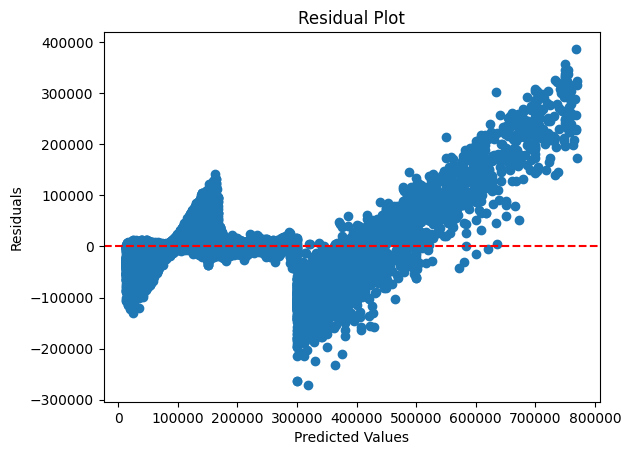

In [408]:
# Plot Residuals
residuals = target_val - model.predict(pd.concat([features_val, w_val], axis=1))
plt.scatter(target_val, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\shap\plots\_beeswarm.py:960: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



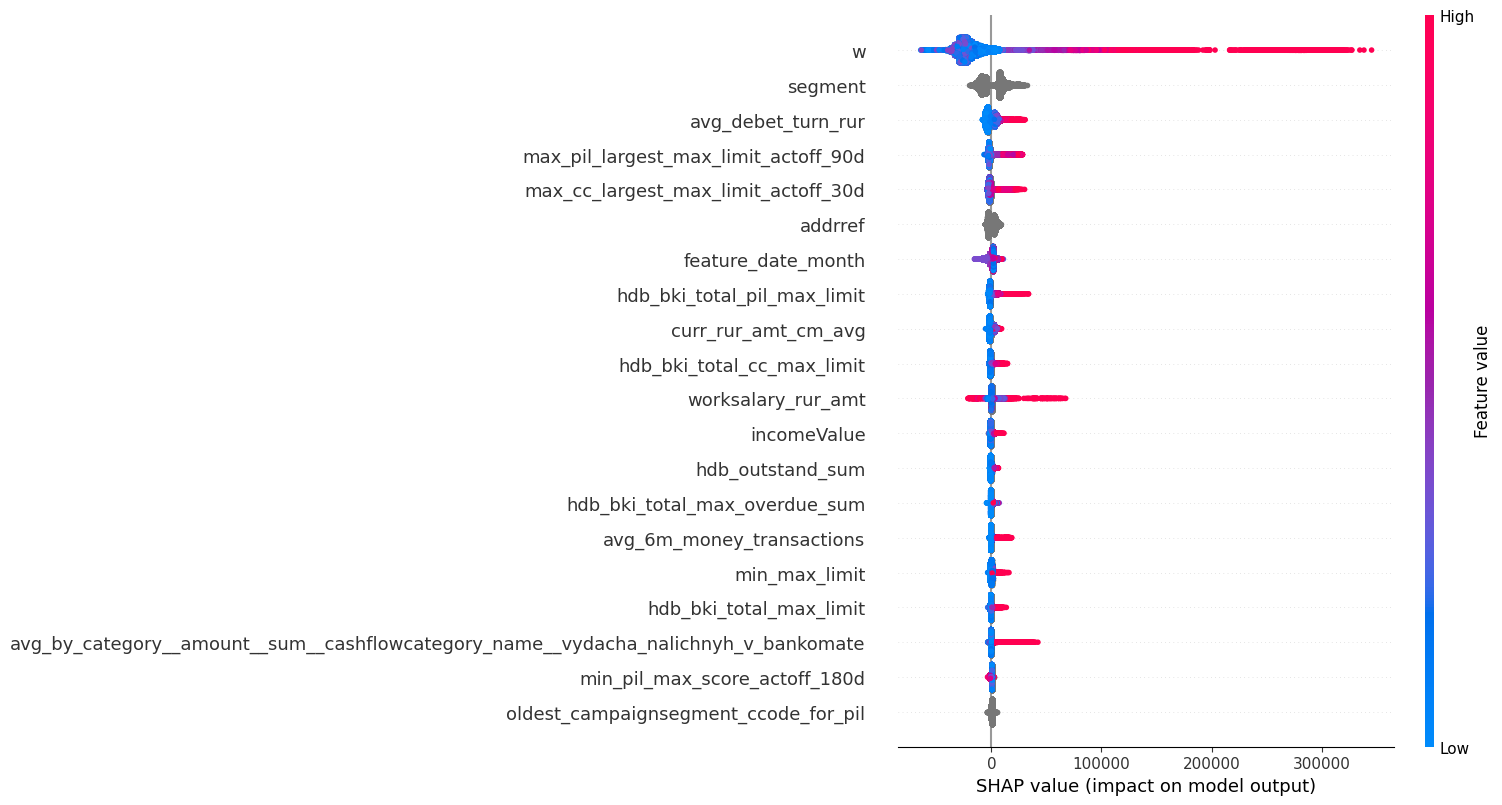

In [409]:
shap_values = (
    shap
    .TreeExplainer(model)
    .shap_values(pd.concat([features_val, w_val], axis=1))
)
shap.summary_plot(shap_values, pd.concat([features_val, w_val], axis=1))

Вывод:  
Если удастся обучить модель для прогнозирования веса (фича 'w'), то можно использовать данное предсказание как фичу и получать хорошую метрику

## Обучение модели на клиентах у которых известны фичи, связанные с должностью или зарплатой

In [410]:
condition_train  = (
    (features_train['main_last_position_ccode'] != 'miss_value')
    | (features_train['main_pre_last_position_ccode'] != 'miss_value')
    | ~(features_train['worksalary_rur_amt'].isna())
)

condition_val  = (
    (features_val['main_last_position_ccode'] != 'miss_value')
    | (features_val['main_pre_last_position_ccode'] != 'miss_value')
    | ~(features_val['worksalary_rur_amt'].isna())
)

features_val.loc[condition_val].shape

(15529, 234)

In [412]:
model = fit_catboost(
    features_train.loc[condition_train], 
    features_val.loc[condition_val], 
    target_train.loc[condition_train], 
    target_val.loc[condition_val], 
    cat_features, 
    300
)

WMAE = weighted_mean_absolute_error(
    target_val.loc[condition_val], 
    model.predict(features_val.loc[condition_val]), 
    w_val.loc[condition_val]
)
print(f"WMAE = {WMAE:.2f}")
print(f"Overfit: {model.evals_result_['validation']['RMSE'][-1] - model.evals_result_['learn']['RMSE'][-1]}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 89987.6395091	test: 90158.4152484	best: 90158.4152484 (0)	total: 60.9ms	remaining: 18.2s
100:	learn: 59758.2124223	test: 60798.6027335	best: 60798.6027335 (100)	total: 7.28s	remaining: 14.3s
200:	learn: 56327.5369237	test: 59055.5348851	best: 59055.5348851 (200)	total: 14.6s	remaining: 7.2s
299:	learn: 53901.4922579	test: 58399.9497057	best: 58399.9497057 (299)	total: 21.6s	remaining: 0us

bestTest = 58399.94971
bestIteration = 299

WMAE = 32163.62
Overfit: 4498.457447854002


Вывод:  
Таких клиентов нет смысла объединять в группу и обучать на них отдельную модель

## Отбор фич (факторный анализ)

In [24]:
# по пропущенным значениям

def feats_filter_nan(df: pd.DataFrame,
                     num_feat: list,
                     cat_feat: list,
                     nan_threshold: float):

    """Функция отбора фичей по доле NaN-значений.
    Фичи, которые имеют долю NaN-значений не ниже заданного nan_threshold, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    num_feat : list
        список числовых фичей
    cat_feat : list
        список категориальных фичей (в нашем случае для них NaN-значением является 'miss_value')
    nan_threshold : float
        порог удаления фичи

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    # для числовых фичей
    nan_stats_num = (
        df[num_feat]
        .isna().mean(axis=0)
        .reset_index()
        .rename(columns={0: 'nan_frac', 'index': 'col'})
    )
    # для категориальных
    nan_stats_cat = (
        (df[cat_feat] == 'miss_value')
        .mean(axis=0)
        .reset_index()
        .rename(columns={0: 'nan_frac', 'index': 'col'})
    )

    nan_stats = pd.concat([nan_stats_num, nan_stats_cat])
    selected_features = list(nan_stats[nan_stats['nan_frac'] < nan_threshold]['col'])

    return selected_features


deleted_features = list(set(features) - set(feats_filter_nan(train_df, num_features, cat_features, 0.95)))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = feats_filter_nan(train_df, num_features, cat_features, 0.95)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

,feature,importance
44,first_salary_income,374.943025
50,hdb_bki_other_active_auto_month_payments_sum,338.462953
60,product_depozity_voc_features_full_voc_without...,248.037231
64,brand,234.652295
79,avg_by_category__amount__sum__cashflowcategory...,69.024693
88,unique_countries1,40.264477
103,min_cc_max_pilot_score_actoff_180d,13.640379
106,channel_pretenzii_voc_features_full_avg_mark,12.769329
110,bki_total_ip_max_limit,9.763157
111,transaction_category_hotels_sum_amt_d15,9.036630


146

Отброшены потенцильно хорошие фичи:
1. first_salary_income
2. hdb_bki_other_active_auto_month_payments_sum
3. brand
4. product_depozity_voc_features_full_voc_without_marks_portion  
  
Вернем их в список фичей

In [25]:
selected_features += [
    'first_salary_income', 
    'hdb_bki_other_active_auto_month_payments_sum', 
    'brand',
    'product_depozity_voc_features_full_voc_without_marks_portion'
]
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

150

In [26]:
# по доле самого частого значения

def feats_filter_nunique(df: pd.DataFrame,
                         features: list,
                         unique_threshold: float):

    """Функция отбора фичей по доле самого частого значения.
    Фичи, которые имеют 1 уникальное значение (помимо NaN), либо для которых
      доля самого частого значения (включая NaN) не ниже unique_threshold, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    features : list
        список фичей
    unique_threshold : float
        порог удаления фичи

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    selected_features = []

    for feat in features:
        if df[feat].nunique() >= 2 and df[feat].astype(str).value_counts(1).values[0] < unique_threshold:
            selected_features += [feat]

    return selected_features

deleted_features = list(set(selected_features) - set(feats_filter_nunique(train_df, selected_features, 0.95)))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = feats_filter_nunique(train_df, selected_features, 0.95)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

,feature,importance
44,first_salary_income,374.943025
50,hdb_bki_other_active_auto_month_payments_sum,338.462953
60,product_depozity_voc_features_full_voc_without...,248.037231
64,brand,234.652295
74,channel_bankomaty_voc_features_full_voc_not_nu...,85.741182
189,loan_on_realty_clicks_90,0.000000
190,channel_otdelenija_voc_features_full_voc_not_n...,0.000000


143

In [33]:
selected_features += [
    'first_salary_income', 
    'hdb_bki_other_active_auto_month_payments_sum', 
    'brand',
    'product_depozity_voc_features_full_voc_without_marks_portion'
]
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

147

In [34]:
# отсечение по рандомной фиче

def feats_filter_random_feat(df: pd.DataFrame,
                             features: list,
                             cat_features: list):

    """Функция отбора фичей при помощи отсечения менее важных фичей чем рандомная фича.
    Фичи, которые имеют в простой модели важность ниже рандомной фичи, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    features : list
        список фичей
    cat_features : list
        список категориальных фичей

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    df['random'] = np.random.uniform(0, 1, df.shape[0])

    pool_train = Pool(
        df[features + ['random']],
        df['target'],
        cat_features = cat_features
    )

    simple_model = CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        loss_function='RMSE',
        random_seed = 42
    )

    simple_model.fit(
        pool_train,
        verbose=100
    )

    shap_values = (
        shap
        .TreeExplainer(simple_model)
        .shap_values(df[features + ['random']])
    )

    model_importance = (
        pd.DataFrame(
            {"feature":  features + ['random'], "importance": np.mean(np.abs(shap_values), axis=0)}
        ).sort_values("importance", ascending=False, ignore_index=True)
    )

    selected_features = list(
        model_importance[
            model_importance['importance'] 
            > model_importance.loc[model_importance['feature'] == 'random', 'importance'].values[0]
        ]['feature']
    )

    return selected_features


_selected_features = feats_filter_random_feat(train_df, selected_features, selected_features_cat)
deleted_features = list(set(selected_features) - set(_selected_features))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = _selected_features
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

0:	learn: 86815.8056799	total: 183ms	remaining: 1m 31s
100:	learn: 61291.4240874	total: 14.3s	remaining: 56.3s
200:	learn: 59210.5992075	total: 28.6s	remaining: 42.5s
300:	learn: 57946.9824982	total: 42.2s	remaining: 27.9s
400:	learn: 56921.5094709	total: 55.4s	remaining: 13.7s
499:	learn: 56140.6982516	total: 1m 8s	remaining: 0us


,feature,importance
68,channel_chatbot_voc_features_12m_mark_in_1_3_flag,160.335868
78,voc_features_full_mark_eq_3_flag,73.801558
80,channel_pretenzii_voc_features_36m_mark_in_1_3...,63.789376
82,channel_ivr_voc_features_full_mark_eq_3_flag,63.042558
89,channel_chat_s_operatorom_voc_features_full_vo...,39.727485
94,channel_chatbot_voc_features_12m_voc_with_expe...,27.127874
102,avg_by_category__amount__sum__cashflowcategory...,13.932098
104,transaction_category_general_store_inc_amt_15d,13.337693
105,prod_page_travel_30,13.072665
108,product_brokerskoe_obsluzhivanie_voc_features_...,12.476172


107

### В чем основные отличия между клиентами с высокой зп и низкой?

In [46]:
print(train_df['target'].quantile(0.90))
train_df.loc[train_df['target'] >= train_df['target'].quantile(0.90)].shape

180000.0


(20627, 239)

In [48]:
train_dd = Dataset(
    train_df.loc[train_df['target'] < train_df['target'].quantile(0.90), selected_features],
    features = selected_features
)
test_dd = Dataset(
    train_df.loc[train_df['target'] >= train_df['target'].quantile(0.90), selected_features],
    features = selected_features
)

check = FeatureDrift(categorical_drift_method = 'PSI', n_top_columns = 30)
check_result = check.run(train_dataset=train_dd, test_dataset=test_dd)
check_result.show()

deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 30 categorical features were inferred.: segment, feature_date_month, addrref, oldest_campaignsegment_ccode_for_nss, feature_date_year, oldest_campaignsegment_ccode_for_pil, channel_mobilnoe_prilozhenie_am_voc_features_12m_mark_eq_1_flag... For full list use dataset.cat_features
deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 30 categorical features were inferred.: segment, feature_date_month, addrref, oldest_campaignsegment_ccode_for_nss, feature_date_year, oldest_campaignsegment_ccode_for_pil, channel_mobilnoe_prilozhenie_am_voc_features_12m_m

### Пробуем выделить группу с высоким доходом
segment = affluent  
first_salary_income > 350к  
max_pil_largest_max_limit_actoff_90d > 3.8  
addrref = Москва  

(76136, 239)


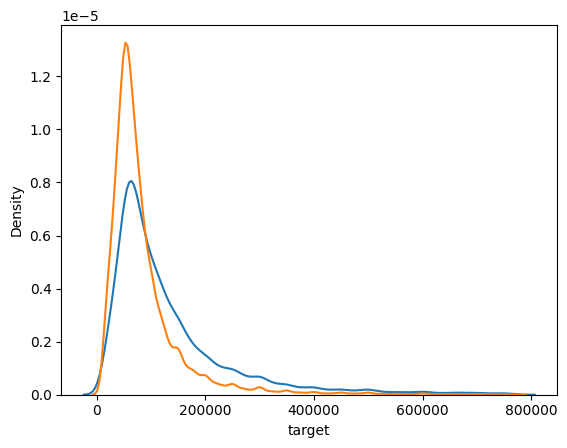

In [33]:
sns.kdeplot(
    train_df.loc[
        (train_df.segment == 'Affluent')
        | (train_df.first_salary_income > 350000)
        | (train_df.max_pil_largest_max_limit_actoff_90d > 3800000)
        | (train_df.addrref == 'г. Москва'),
        'target'
    ]
)
sns.kdeplot(
    train_df.loc[
        (train_df.segment != 'Affluent')
        | (train_df.first_salary_income <= 350000)
        | (train_df.max_pil_largest_max_limit_actoff_90d <= 3800000)
        | (train_df.addrref != 'г. Москва'),
        'target'
    ]
)

print(
    train_df.loc[
        (train_df.segment == 'Affluent')
        | (train_df.first_salary_income > 350000)
        | (train_df.max_pil_largest_max_limit_actoff_90d > 3800000)
        | (train_df.addrref == 'г. Москва')
    ].shape
)

## Обучение модели на фичах после факторного анализа

In [35]:
model = fit_catboost(
    features_train[selected_features], 
    features_val[selected_features], 
    target_train, 
    target_val, 
    selected_features_cat, 
    500
)

WMAE = weighted_mean_absolute_error(target_val, model.predict(features_val[selected_features]), w_val)
print(f"WMAE = {WMAE:.2f}")
print(f"Overfit: {model.evals_result_['validation']['RMSE'][-1] - model.evals_result_['learn']['RMSE'][-1]}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 86747.5860459	test: 86949.1841070	best: 86949.1841070 (0)	total: 117ms	remaining: 58.4s
100:	learn: 61202.6881553	test: 61652.1968018	best: 61652.1968018 (100)	total: 12.1s	remaining: 47.8s
200:	learn: 59005.4863056	test: 60000.5161424	best: 60000.5161424 (200)	total: 24.2s	remaining: 36.1s
300:	learn: 57588.0591255	test: 59174.3454054	best: 59174.3454054 (300)	total: 35.8s	remaining: 23.7s
400:	learn: 56453.0778408	test: 58719.6639479	best: 58719.6639479 (400)	total: 47.5s	remaining: 11.7s
499:	learn: 55531.8996412	test: 58407.8244789	best: 58407.8244789 (499)	total: 59.3s	remaining: 0us

bestTest = 58407.82448
bestIteration = 499

WMAE = 31531.77
Overfit: 2875.9248377072145


Text(0.5, 1.0, 'Residual Plot')

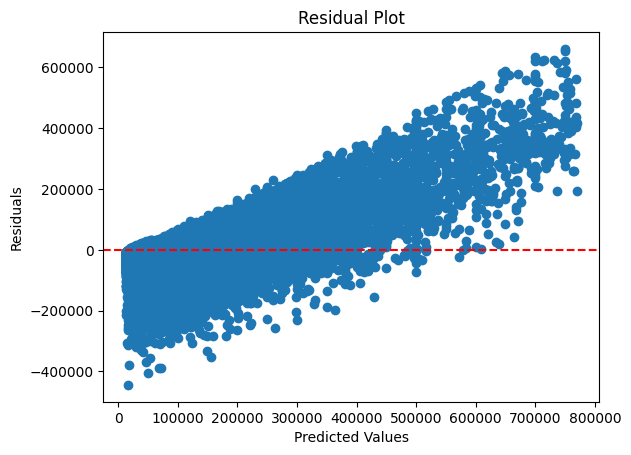

In [36]:
# Plot Residuals
residuals = target_val - model.predict(features_val[selected_features])
plt.scatter(target_val, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\shap\plots\_beeswarm.py:960: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



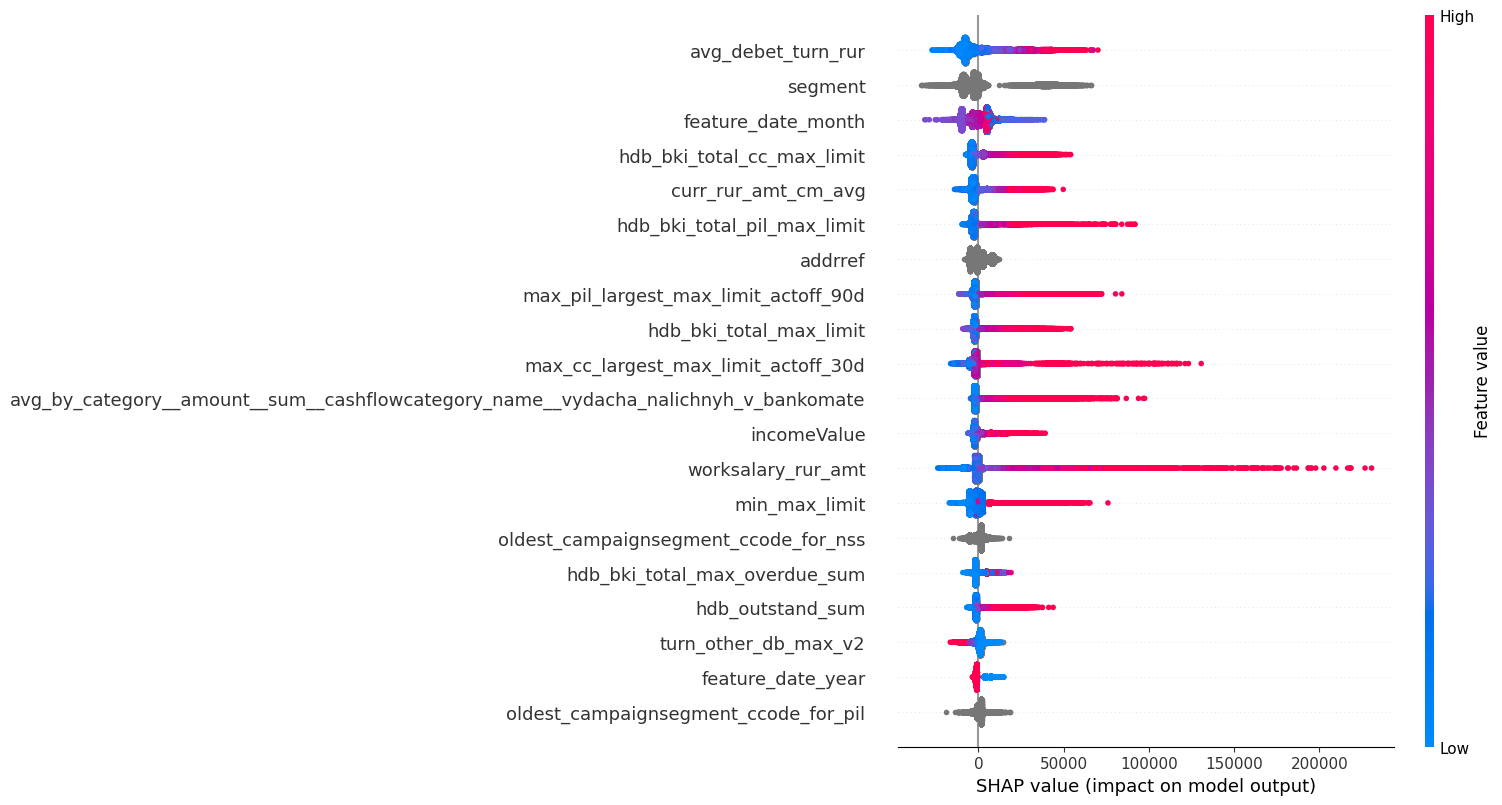

In [37]:
shap_values = (
    shap
    .TreeExplainer(model)
    .shap_values(features_val[selected_features])
)
shap.summary_plot(shap_values, features_val[selected_features])

## Улучшиться ли качество модели, если разбить датасет на бины по таргету?
Насколько улучшится общее качество, если обучить по модели на каждый бин? Будем рассматривать варинты разбиения на 2 и 3 бина и подбирать оптимальные размеры бинов по квантилям.

Разбиение на 2 бина:

0:	learn: 5781.1865278	test: 5790.2508944	best: 5790.2508944 (0)	total: 33.6ms	remaining: 16.8s
100:	learn: 5171.9552315	test: 5277.4153435	best: 5277.4153435 (100)	total: 4.35s	remaining: 17.2s
200:	learn: 5023.5913824	test: 5222.0417045	best: 5222.0417045 (200)	total: 8.94s	remaining: 13.3s
300:	learn: 4876.9917747	test: 5183.9176973	best: 5183.9176973 (300)	total: 13.6s	remaining: 9s
400:	learn: 4764.4572421	test: 5168.5263636	best: 5168.5263636 (400)	total: 18.1s	remaining: 4.46s
499:	learn: 4656.6692412	test: 5156.3494028	best: 5156.1651697 (493)	total: 22.5s	remaining: 0us

bestTest = 5156.16517
bestIteration = 493

Shrink model to first 494 iterations.
0:	learn: 88141.7068421	test: 88311.3277742	best: 88311.3277742 (0)	total: 117ms	remaining: 58.5s
100:	learn: 62545.1063545	test: 63051.4691820	best: 63051.4691820 (100)	total: 10.9s	remaining: 43.2s
200:	learn: 60404.2778658	test: 61445.0032382	best: 61445.0032382 (200)	total: 22s	remaining: 32.8s
300:	learn: 58931.4555792	test: 

Text(0, 0.5, 'wmae')

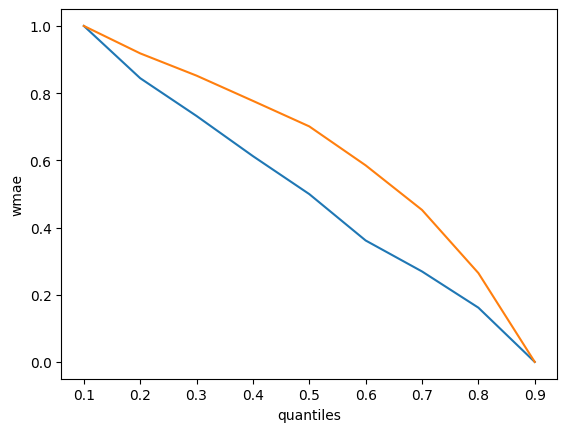

In [357]:
big_target_value = train_df['target'].quantile(0.9)
median_target_value = train_df['target'].quantile(0.5)
quantiles = np.arange(0.1, 1, 0.1)
wmae_list = []
rmse_list = []

for q in quantiles:

    threshold_q = train_df['target'].quantile(q)

    b0_model = fit_catboost(
        features_train.loc[target_train <= threshold_q, selected_features], 
        features_val.loc[target_val <= threshold_q, selected_features], 
        target_train.loc[target_train <= threshold_q], 
        target_val.loc[target_val <= threshold_q], 
        selected_features_cat, 
        500,
        plot=False
    )
    b0_pred = b0_model.predict(features_val.loc[target_val <= threshold_q, selected_features])

    b1_model = fit_catboost(
        features_train.loc[target_train > threshold_q, selected_features], 
        features_val.loc[target_val > threshold_q, selected_features], 
        target_train.loc[target_train > threshold_q], 
        target_val.loc[target_val > threshold_q], 
        selected_features_cat, 
        500,
        plot=False
    )
    b1_pred = b1_model.predict(features_val.loc[target_val > threshold_q, selected_features])

    pred_df = pd.DataFrame(None, index=target_val.index, columns=['pred'])
    pred_df.loc[target_val <= threshold_q, 'pred'] = b0_pred
    pred_df.loc[target_val > threshold_q, 'pred'] = b1_pred

    wmae = weighted_mean_absolute_error(target_val, pred_df['pred'], w_val)
    wmae_list.append(wmae)

    rmse = np.sqrt(mean_squared_error(target_val, pred_df['pred']))
    rmse_list.append(rmse)

    print(f'WMAE:{wmae}, RMSE:{rmse}\n')

mms = MinMaxScaler()
plt.plot(quantiles, mms.fit_transform(np.array(wmae_list).reshape(-1, 1)))
plt.plot(quantiles, mms.fit_transform(np.array(rmse_list).reshape(-1, 1)))
plt.xlabel("quantiles")
plt.ylabel("wmae")

Разбиение на 3 бина:

Подбор для q0=0.1------------------------------------------

Начало фолда.

0:	learn: 5776.6768584	test: 5793.5254356	best: 5793.5254356 (0)	total: 42.2ms	remaining: 21.1s
100:	learn: 5157.3091417	test: 5275.5070663	best: 5275.5070663 (100)	total: 4.87s	remaining: 19.2s
200:	learn: 5012.1638830	test: 5233.3775469	best: 5233.3775469 (200)	total: 9.35s	remaining: 13.9s
300:	learn: 4866.8422381	test: 5198.1177040	best: 5198.1177040 (300)	total: 13.7s	remaining: 9.06s
400:	learn: 4747.7585257	test: 5187.7573388	best: 5186.9708533 (395)	total: 17.8s	remaining: 4.41s
Stopped by overfitting detector  (15 iterations wait)

bestTest = 5186.970853
bestIteration = 395

Shrink model to first 396 iterations.
0:	learn: 3050.3080714	test: 3080.4152694	best: 3080.4152694 (0)	total: 36.6ms	remaining: 18.3s
100:	learn: 2868.2607585	test: 2942.7388347	best: 2942.7388347 (100)	total: 4.33s	remaining: 17.1s
200:	learn: 2809.7240152	test: 2933.6688186	best: 2933.6688186 (200)	total: 8.64s	remaining: 12.9s
3

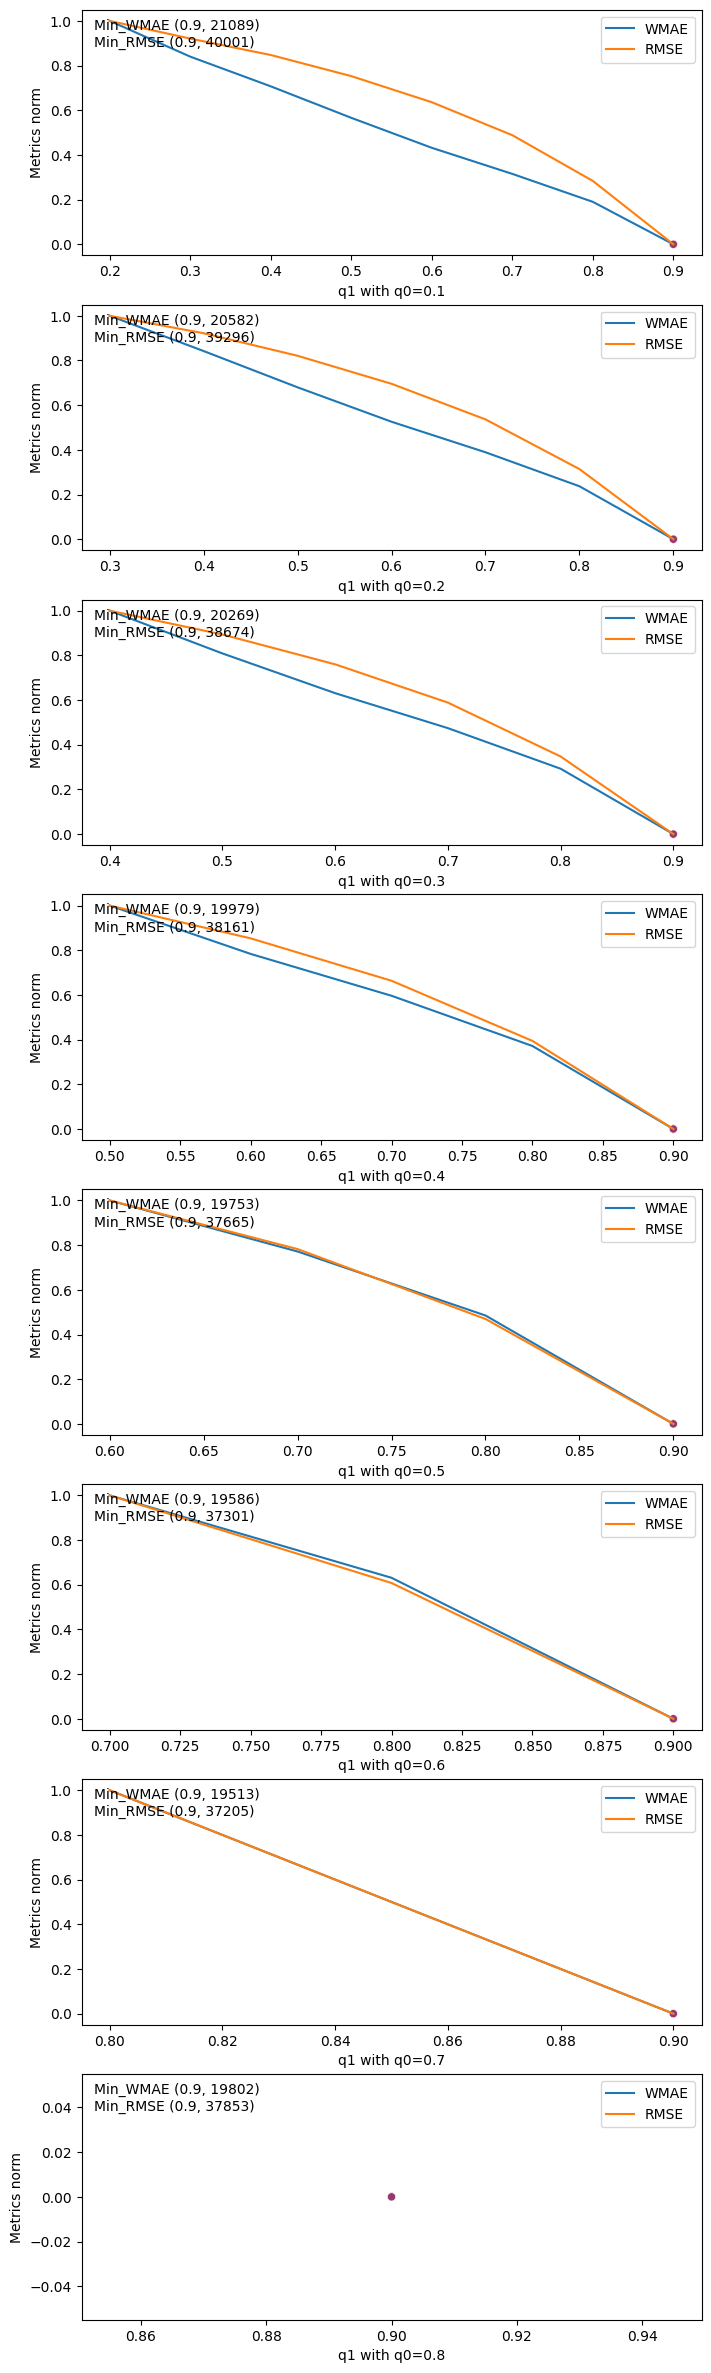

In [63]:
fig, axes = plt.subplots(8, 1, figsize=(8, 30))
quantiles = np.round(np.arange(0.1, 1, 0.1), 2)

for q0 in quantiles:

    print(f'Подбор для q0={q0}------------------------------------------\n')

    ax = axes[int(q0*10)%9-1]
    wmae_lists = []
    rmse_lists = []

    bin0_threshold = train_df['target'].quantile(q0)

    if not np.where(quantiles > q0)[0].size:
        break


    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(train_df):
        print(f'Начало фолда.\n')
        wmae_list_fold = []
        rmse_list_fold = []

        cross_f_train, cross_f_val = train_df[features].loc[train_index], train_df[features].loc[val_index]
        cross_t_train, cross_t_val = train_df['target'].loc[train_index], train_df['target'].loc[val_index]
        cross_w_train, cross_w_val = train_df['w'].loc[train_index], train_df['w'].loc[val_index]

        # модель для нулевого бина
        b0_model = fit_catboost(
            cross_f_train.loc[cross_t_train <= bin0_threshold, selected_features], 
            cross_f_val.loc[cross_t_val <= bin0_threshold, selected_features], 
            cross_t_train.loc[cross_t_train <= bin0_threshold], 
            cross_t_val.loc[cross_t_val <= bin0_threshold], 
            selected_features_cat, 
            500,
            plot=False
        )
        b0_pred = b0_model.predict(cross_f_val.loc[cross_t_val <= bin0_threshold, selected_features])

        q1s = quantiles[np.where(quantiles > q0)[0][0]:]

        for q1 in q1s:

            bin1_threshold = train_df['target'].quantile(q1)
            
            # модель для первого бина
            b1_model = fit_catboost(
                cross_f_train.loc[
                    (cross_t_train <= bin1_threshold) & (cross_t_train > bin0_threshold), 
                    selected_features
                ], 
                cross_f_val.loc[
                    (cross_t_val <= bin1_threshold) & (cross_t_val > bin0_threshold), 
                    selected_features
                ], 
                cross_t_train.loc[(cross_t_train <= bin1_threshold) & (cross_t_train > bin0_threshold)], 
                cross_t_val.loc[(cross_t_val <= bin1_threshold) & (cross_t_val > bin0_threshold)], 
                selected_features_cat, 
                500,
                plot=False
            )
            b1_pred = b1_model.predict(
                cross_f_val.loc[
                    (cross_t_val <= bin1_threshold) & (cross_t_val > bin0_threshold), 
                    selected_features
                ]
            )

            # модель для второго бина
            b2_model = fit_catboost(
                cross_f_train.loc[cross_t_train > bin1_threshold, selected_features], 
                cross_f_val.loc[cross_t_val > bin1_threshold, selected_features], 
                cross_t_train.loc[cross_t_train > bin1_threshold], 
                cross_t_val.loc[cross_t_val > bin1_threshold], 
                selected_features_cat, 
                500,
                plot=False
            )
            b2_pred = b2_model.predict(cross_f_val.loc[cross_t_val > bin1_threshold, selected_features])

            # получаем общую метрику по трем моделям
            pred_df = pd.DataFrame(None, index=cross_t_val.index, columns=['pred'])
            pred_df.loc[cross_t_val <= bin0_threshold, 'pred'] = b0_pred
            pred_df.loc[(cross_t_val <= bin1_threshold) & (cross_t_val > bin0_threshold), 'pred'] = b1_pred
            pred_df.loc[cross_t_val > bin1_threshold, 'pred'] = b2_pred

            wmae = weighted_mean_absolute_error(cross_t_val, pred_df['pred'], cross_w_val)
            wmae_list_fold.append(wmae)

            rmse = np.sqrt(mean_squared_error(cross_t_val, pred_df['pred']))
            rmse_list_fold.append(rmse)

            print(f'WMAE:{wmae}, RMSE:{rmse}\n')
        wmae_lists.append(wmae_list_fold)
        rmse_lists.append(rmse_list_fold)

    print(wmae_lists)
    print(rmse_lists)


    mms = MinMaxScaler()
    norm_wmae = mms.fit_transform(np.mean(np.array(wmae_lists), axis=0).reshape(-1, 1))
    norm_rmse = mms.fit_transform(np.mean(np.array(rmse_lists), axis=0).reshape(-1, 1))

    df = pd.DataFrame(
        {
            'q1': np.concatenate((q1s, q1s)), 
            'metric_norm': np.concatenate((norm_wmae, norm_rmse)).reshape(-1), 
            'metric': np.concatenate((np.mean(np.array(wmae_lists), axis=0), np.mean(np.array(rmse_lists), axis=0)), axis=0),
            'metric_name': ['WMAE'] * len(q1s) + ['RMSE'] * len(q1s)
        }
    )
    min_m_indices = df.groupby('metric_name')['metric'].idxmin()

    sns.lineplot(data=df, x='q1', y='metric_norm', hue='metric_name', ax=ax)
    sns.scatterplot(
        data=df.loc[min_m_indices], 
        x="q1", y='metric_norm', hue='metric_name', 
        legend=False, palette='flare', ax=ax
    )
    plt.text(
        0.02, 0.85, 
        f"Min_RMSE ({df.loc[min_m_indices.RMSE, 'q1']}, {round(df.loc[min_m_indices.RMSE, 'metric'])})", 
        fontsize=10, transform=ax.transAxes
    )
    plt.text(
        0.02, 0.92, 
        f"Min_WMAE ({df.loc[min_m_indices.WMAE, 'q1']}, {round(df.loc[min_m_indices.WMAE, 'metric'])})", 
        fontsize=10, transform=ax.transAxes
    )
    ax.set(xlabel=f'q1 with q0={q0}', ylabel='Metrics norm')
    ax.legend(loc='upper right')

#### Вывод: 
Лучшие метрики получаются при разбиении датасета на 3 бина по таргету. Лучшие границы - 0.7 и 0.9 квантили.  
* UPD: при разбиении датасета на бине с границами 0.7 и 0.9 квантилями получена плохая метрика на скрытой выборке. Принято решение добавить кроссвалидацию для подбора границ.  
* UPD2: выяснено, что при использовании границ 0.7 и 0.9 финальные регрессоры сильно переобучаются, поэтому метрика хуже. Анализ в файле 08_ensemble_analysis

# Инференс

In [427]:
pool_train = Pool(
    train_df[selected_features],
    train_df['target'],
    cat_features = selected_features_cat
)

model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    loss_function='RMSE'
)

model.fit(
    pool_train,
    verbose=100,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 86783.4729163	total: 139ms	remaining: 1m 9s
100:	learn: 61331.0914959	total: 12.9s	remaining: 51.1s
200:	learn: 59243.5031000	total: 25.9s	remaining: 38.5s
300:	learn: 57950.4277999	total: 38.8s	remaining: 25.6s
400:	learn: 56958.9794654	total: 52.2s	remaining: 12.9s
499:	learn: 56180.6017832	total: 1m 5s	remaining: 0us


# Commit

In [428]:
test_df['predict'] = model.predict(test_df[selected_features])
test_df[['client_id','predict']].set_index('client_id').to_csv("data/commit.csv", sep=",", decimal=".")